# The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [0]:
%tensorflow_version 1.x
from keras.datasets import cifar10
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [10]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [11]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, \
Activation, Flatten, Lambda
from keras import regularizers
from keras.optimizers import RMSprop, Adam
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend as K

# Learning params:

num_classes = 5
learning_rate = 0.0001
batch_size = 32    
num_epochs = 50

# Extraction of the train data with num_classes != 10:

x_train_bis, y_train_bis = [], []
x_test_bis, y_test_bis = [], []
x_other, y_other = [], []

if num_classes != 10:
  for i in range(x_train.shape[0]):
    if y_train[i,0] < num_classes:
      x_train_bis.append(x_train[i])
      y_train_bis.append(y_train[i])
    else:
      x_other.append(x_train[i])
      y_other.append(y_train[i])
  for i in range(x_test.shape[0]):
    if y_test[i,0] < num_classes:
      x_test_bis.append(x_test[i])
      y_test_bis.append(y_test[i])
    else:
      x_other.append(x_test[i])
      y_other.append(y_test[i])

x_train_bis = np.array(x_train_bis, dtype = np.float32)
y_train_bis = np.array(y_train_bis, dtype = int)
x_test_bis = np.array(x_test_bis, dtype = np.float32)
y_test_bis = np.array(y_test_bis, dtype = int)
x_other = np.array(x_other, dtype = np.float32)
y_other = np.array(y_other, dtype = int)

print("Train set:", x_train_bis.shape[0], "images")
print("Test set:", x_test_bis.shape[0], "images")
print("X Other classes:", x_other.shape[0])

y_train_bis = np_utils.to_categorical(y_train_bis, num_classes) # One-hot encode the labels
y_test_bis = np_utils.to_categorical(y_test_bis, num_classes)
y_train_bis = y_train_bis.astype('int')
y_test_bis = y_test_bis.astype('int')

Train set: 25000 images
Test set: 5000 images
X Other classes: 30000


# CNN Definition

In [12]:
# --------------------------------------
# CNN network definition
# --------------------------------------

# Network params
  
conv_depth_1 = 100
kernel_size_1 = 3

conv_depth_2 = 100 
kernel_size_2 = 3
pool_size_2 = 2

conv_depth_3 = 200 
kernel_size_3 = 3

conv_depth_4 = 200 
kernel_size_4 = 3

conv_depth_5 = 400 
kernel_size_5 = 3
pool_size_5 = 2

hidden_size_1 = 600

weight_penalty = 0.0001 


model = Sequential()

model.add(Conv2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same',
                 input_shape=x_train_bis.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(conv_depth_2, (kernel_size_2, kernel_size_2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size_2, pool_size_2)))
model.add(Dropout(0.3))

model.add(Conv2D(conv_depth_3, (kernel_size_3, kernel_size_3), padding='same', 
                 kernel_regularizer=regularizers.l2(weight_penalty)))
model.add(Activation('relu'))

model.add(Conv2D(conv_depth_4, (kernel_size_4, kernel_size_4), padding='same',
                 kernel_regularizer=regularizers.l2(weight_penalty)))
model.add(Activation('relu'))

model.add(Conv2D(conv_depth_5, (kernel_size_5, kernel_size_5), padding='same', 
                 kernel_regularizer=regularizers.l2(weight_penalty)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size_5, pool_size_5)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(hidden_size_1, 
                kernel_regularizer=regularizers.l2(weight_penalty)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 100)       2800      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 100)       90100     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 100)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 100)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 100)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 200)      

In [13]:
from keras.models import load_model
from google.colab import auth, drive
drive.mount('/content/drive')
path_in_the_drive = '/content/drive/My Drive/Cours/IASD/Projets/One_Shot_Learning/'
model_name = "official_CNN_on_Cifar.h5"

# # Training on whole dataset

# # With Data Augmentation:

# opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
# # #opt = RMSprop(lr=learning_rate,decay=1e-6)
# x_train_bis, x_val, y_train_bis, y_val = train_test_split(x_train_bis, 
#                                                            y_train_bis, 
#                                                            test_size=0.2, 
#                                                            random_state=1)

# train_datagen = ImageDataGenerator(rescale=1, rotation_range=2, 
#                                    width_shift_range=0.15, 
#                                    height_shift_range=0.15, 
#                                    shear_range=0.1, zoom_range=0.1, 
#                                    horizontal_flip=True)
# train_set = train_datagen.flow(x_train_bis, y_train_bis, batch_size=batch_size)

# validation_datagen = ImageDataGenerator(rescale=1)
# validation_set = validation_datagen.flow(x_val, y_val, batch_size=batch_size)

# model.compile(loss='categorical_crossentropy',
#               optimizer=opt, metrics=['accuracy'])

# history = model.fit_generator(train_set, steps_per_epoch=600,
#                               epochs=num_epochs , verbose = True,
#                               validation_data=(validation_set),
#                               validation_steps=300, shuffle=True)

# # Without Data Augmentation:

# opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
# #opt = RMSprop(lr=learning_rate,decay=1e-6)

# model.compile(loss='categorical_crossentropy', 
#                optimizer=opt, metrics=['accuracy'])
# history = model.fit(x_train_bis, y_train_bis, verbose = True, 
#                     epochs = num_epochs , batch_size=batch_size,
#                     validation_split=0.2, shuffle = True)

# # Saving the model on a drive

# model.save(path_in_the_drive + model_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the model from the drive:

In [14]:
model = load_model(path_in_the_drive + model_name)

# Test

print("Performance on train:", model.evaluate(x_train_bis, y_train_bis))
print("Performance on test:", model.evaluate(x_test_bis, y_test_bis))

25000/25000 [==============================] - 4s 173us/step
Performance on train: [0.3177703296470642, 0.94716]
5000/5000 [==============================] - 1s 164us/step
Performance on test: [0.45617241077423093, 0.9024]


Plotting the loss evolution during training.

In [0]:
# import matplotlib.pyplot as plt

# loss = history.history["loss"]
# val_loss = history.history["val_loss"]
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, "bo", label="Training loss")
# plt.plot(epochs, val_loss, "b", label="Validation loss")
# plt.title("Training and validation loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# Feature extraction

We need to use the representation of the image in order to see if by learning on k classes, we are able to differentiate other classes.

In order to do so, we need to recreate a model based on the previous one but with an output that will be the penultimate layer.

In [16]:
import numpy as np

nb_examples = 1000

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-3].output)

results = intermediate_layer_model.predict(x_other)

state = True
i = 0
results_per_class = [0]*(10-num_classes)
while state:
  x = intermediate_layer_model.predict(np.array([x_other[i]]))[0]
  y = y_other[i,0]
  if type(results_per_class[y - num_classes]) == type(0): 
    results_per_class[y - num_classes] = [x]
  else:
    if len(results_per_class[y - num_classes]) < nb_examples:
      results_per_class[y - num_classes].append(x)
    else:
      stop = True
      for elem in results_per_class:
        if type(elem) == type(0): 
          stop = False
          break
        if len(elem) < nb_examples:
          stop = False
          break
      if stop: state = False
  i += 1
results_per_class = np.array(results_per_class)
print(results_per_class.shape)

(5, 1000, 600)


Size of the dataframe: (30000, 602)
Explained variation per   principal component: [0.41563362 0.1159159  0.08875708]
Size of the dataframe: (4000, 605)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


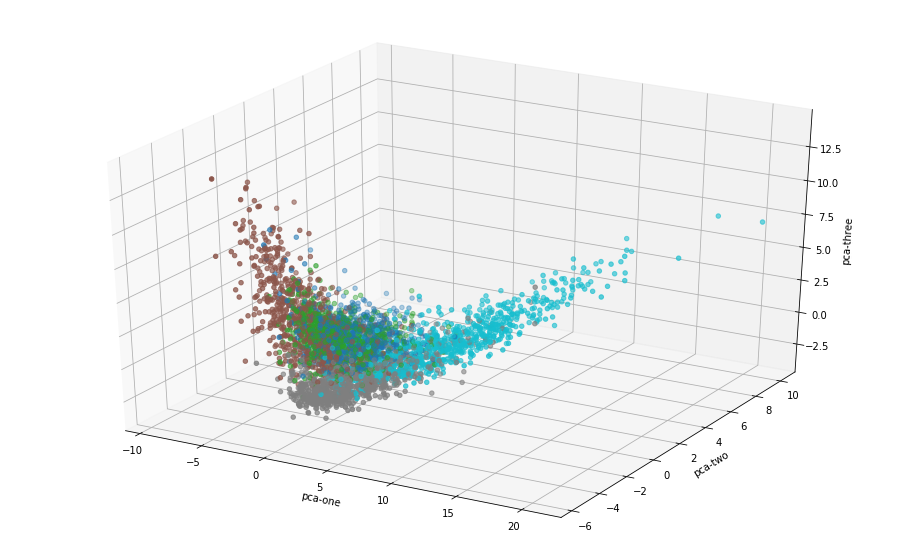

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.123s...
[t-SNE] Computed neighbors for 4000 samples in 19.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 1.419724
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.709274
[t-SNE] KL divergence after 300 iterations: 2.089915
t-SNE done! Time elapsed: 29.47120690345764 seconds


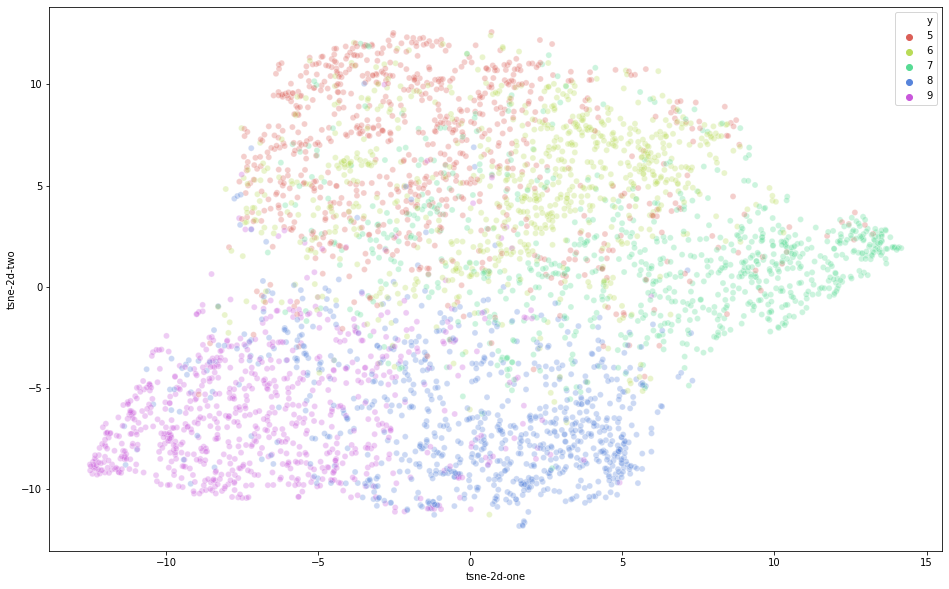

In [17]:
from __future__ import print_function
import time
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

N = 4000
feat_cols = [ 'index'+str(i) for i in range(results.shape[1]) ]
df = pd.DataFrame(results,columns=feat_cols)
df['y'] = y_other
df['label'] = df['y'].apply(lambda i: str(i))
print('Size of the dataframe: {}'.format(df.shape))

########### PCA ##########
# np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per \
  principal component: {}'.format(pca.explained_variance_ratio_))
print('Size of the dataframe: {}'.format(df_subset.shape))
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset.loc[rndperm,:]["pca-one"], 
    ys=df_subset.loc[rndperm,:]["pca-two"], 
    zs=df_subset.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

######## T-SNE Method ########
data_subset = df_subset[feat_cols].values
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",hue="y",
    palette=sns.color_palette("hls", 10-num_classes),
    data=df_subset, legend="full", alpha=0.3)

# Prediction with one nearest neighbor

We select as reference one example of each class and we will evaluate the precision of an algorithm that attributes an unkown image to the nearest reference.

In [18]:
import random as rd

def compute_nearest_neighbor(vector, data_set):
  """ 
  This function returns the index of the nearest neighbor in the data_set
  while making sure that this neighbor is similar to vector.
  INPUTS:
  - vector: array of coordinates of the same dimension of the vectors in 
  data_set
  - data_set: array of vectors.
  OUTPUT:
  - nn: index of the nearest_neighbor.
  COMPUTATION TIME:
  Immediate
  """
  mini = 1000000
  nn = 0
  for i in range(data_set.shape[0]):
    elem = data_set[i,:]
    dist = np.linalg.norm(vector - elem)
    if dist != 0.:
      if dist < mini:
        nn = i
        mini = dist
  return nn

# # Test compute_nearest_neighbor:

# data_set = [[0,0], [1,4], [1,1]]
# data_set = np.array(data_set)
# vector = np.array([0,0])
# print(compute_nearest_neighbor(vector, data_set))

# Tests:
confusion_matrix = np.zeros((10-num_classes, 10 - num_classes), dtype = int)
# ligne : prediction
# colonne : reference
nb_of_different_references = 300
accuracies = np.zeros((10-num_classes, nb_of_different_references))
for p in range(nb_of_different_references):
  index_ref = rd.randint(0, nb_examples-1)
  references = results_per_class[:,index_ref]
  for i in range(10-num_classes):
    nb_mistakes = 0
    k = 0
    for elem in results_per_class[i,:]:
      if k != index_ref:
        index = compute_nearest_neighbor(elem, references)
        confusion_matrix[index, i] += 1
        if index != i:
          nb_mistakes += 1
      k += 1
    accuracies[i, p] = 1 - nb_mistakes/(nb_examples-1)  
for num_class in range(10-num_classes):
  print("Class n°", num_class+num_classes,"accuracy:", 
        np.mean(accuracies[num_class,:]))
print("Confusion Matrix:")
print(confusion_matrix)

Class n° 5 accuracy: 0.40679346012679346
Class n° 6 accuracy: 0.52671004337671
Class n° 7 accuracy: 0.42882549215882554
Class n° 8 accuracy: 0.616393059726393
Class n° 9 accuracy: 0.5674140807474141
Confusion Matrix:
[[121916  74187  51902  12757   8158]
 [121478 157855  92907  26502  14940]
 [ 43546  46394 128519  22304  10420]
 [  8450  13502  19013 184733  96128]
 [  4310   7762   7359  53404 170054]]


# Few shots learning


In [19]:
# Tests:
confusion_matrix = np.zeros((10-num_classes, 10 - num_classes), dtype = int)
# ligne : prediction
# colonne : reference
nb_of_different_references = 100
accuracies = np.zeros((10-num_classes, nb_of_different_references))
for p in range(nb_of_different_references):
  index_ref = rd.randint(0, nb_examples-3)
  references = results_per_class[:,index_ref] + results_per_class[:, index_ref +1 ] + \
  results_per_class[:,index_ref+2]
  references /= 3
  for i in range(10-num_classes):
    nb_mistakes = 0
    k = 0
    for elem in results_per_class[i,:]:
      if k != index_ref:
        index = compute_nearest_neighbor(elem, references)
        confusion_matrix[index, i] += 1
        if index != i:
          nb_mistakes += 1
      k += 1
    accuracies[i, p] = 1 - nb_mistakes/(nb_examples-1)  
for num_class in range(10-num_classes):
  print("Class n°", num_class+num_classes,"accuracy:", 
        np.mean(accuracies[num_class,:]))
print("Confusion Matrix:")
print(confusion_matrix)

Class n° 5 accuracy: 0.5292392392392391
Class n° 6 accuracy: 0.5803003003003003
Class n° 7 accuracy: 0.5749349349349351
Class n° 8 accuracy: 0.7300900900900901
Class n° 9 accuracy: 0.7108308308308309
Confusion Matrix:
[[52871 24139 12902  2534  1160]
 [34236 57972 23353  4927  2682]
 [10766 12284 57436  4504  1868]
 [ 1425  3878  5036 72936 23178]
 [  602  1627  1173 14999 71012]]


# Siamese Network with an embedded CNN

**Data preparation for Siamese utilisation**

In [0]:
class Data_Cifar_10:
  def __init__(self):
    self.prepare_data()
    self.group_data()

  def prepare_data(self):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    self.img_rows = x_train.shape[1]
    self.img_cols = x_train.shape[2]
    self.input_shape = (self.img_rows, self.img_cols,3)

    x_train = x_train.reshape(-1, self.img_rows, self.img_cols, 3)
    x_test = x_test.reshape(-1, self.img_rows, self.img_cols, 3)
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train /= 255.
    x_test /= 255.
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test

  def group_data(self):
    self.grouped_data = {}
    self.grouped_test_data = {}
    for i in range(10):
      #self.grouped_data[i] = self.x_train[self.y_train==i]
      #elf.grouped_test_data[i] = self.x_test[self.y_test==i]
      self.grouped_data[i] = self.x_train[np.argwhere(self.y_train==i)[:,0]]
      self.grouped_test_data[i] = self.x_test[np.argwhere(self.y_test==i)[:,0]]

  def get_batch(self, num_list, flag='train'):
    target = []
    batch = []
    if flag  == 'train':
      data_ = self.grouped_data
    else:
      data_ = self.grouped_test_data
    num_example = min([data_[i].shape[0] for i in num_list])

    for i in range(num_example*num_classes):
      i1,i2 = np.random.choice(num_list,2, replace=False)
      i_index = np.random.choice(num_example,4, replace=False)
      batch += [[data_[i1][i_index[0]], data_[i1][i_index[1]]]]
      batch += [[data_[i1][i_index[2]], data_[i2][i_index[3]]]]
      target.append(1)
      target.append(0)
    return np.array(batch), np.array(target)

  def get_test_batch(self, test_size, test_target, categ_target, k=10):#k-way one shot learning
    batch = [np.zeros((test_size*k, self.img_rows, self.img_cols,3)) for i in range(2)]
    # batch = []
    target = [] # index of correct category
    num_list = test_target
    categ_list = categ_target
    data_ = self.grouped_data
    for i in range(test_size):
      i1 = np.random.choice(num_list)
      i1_index = np.random.choice(data_[i1].shape[0])
      batch[0][i*k:i*k+k,:] = np.repeat(data_[i1][i1_index][np.newaxis,:], k, axis=0)
      target.append(i1)
      for k_i in range(k):
        i2_index = np.random.choice(data_[categ_list[k_i]].shape[0])
        batch[1][i*k+k_i,:] = data_[categ_list[k_i]][i2_index]
        while categ_list[k_i]==i1 and i2_index == i1_index:
          i2_index = np.random.choice(data_[categ_list[k_i]].shape[0])
          batch[1][i*k+k_i,:] = data_[categ_list[k_i]][i2_index] 
    return batch, target

train_num_list = list(range(num_classes))
val_num_list = list(range(num_classes))
test_num_list = list(range(num_classes))
all_num_list = list(range(10))

**Siamese Structure**

In [21]:
# --------------------------------------
# Siamese CNN network definition 
# --------------------------------------

def get_siamese_model(input_shape, distance = 'l1'):
   
  # # Network params
      
  conv_depth_1 = 100
  kernel_size_1 = 3
  
  conv_depth_2 = 100 
  kernel_size_2 = 3
  pool_size_2 = 2
    
  conv_depth_3 = 200 
  kernel_size_3 = 3
    
  conv_depth_4 = 200 
  kernel_size_4 = 3
    
  conv_depth_5 = 200 
  kernel_size_5 = 3
  pool_size_5 = 2
    
  hidden_size_1 = 600

  hidden_size_2 = 300
    
  weight_penalty = 0.0001 
  
  left_input = Input(input_shape, name='input1')
  right_input = Input(input_shape, name='input2')

  model = Sequential(name = "CNN_embedded")

  model.add(Conv2D(conv_depth_1, (kernel_size_1, kernel_size_1), 
                   padding='same',
                   input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(Conv2D(conv_depth_2, (kernel_size_2, kernel_size_2), 
                   padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(pool_size_2, pool_size_2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(conv_depth_3, (kernel_size_3, kernel_size_3), 
                   padding='same', 
                   kernel_regularizer=regularizers.l2(weight_penalty)))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
    
  model.add(Conv2D(conv_depth_4, (kernel_size_4, kernel_size_4), 
                   padding='same',
                   kernel_regularizer=regularizers.l2(weight_penalty)))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
    
  model.add(Conv2D(conv_depth_5, (kernel_size_5, kernel_size_5), 
                   padding='same', 
                   kernel_regularizer=regularizers.l2(weight_penalty)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(pool_size_5, pool_size_5)))
  model.add(Dropout(0.3))
  
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(hidden_size_1, 
                  kernel_regularizer=regularizers.l2(weight_penalty)))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(hidden_size_2,
                  kernel_regularizer=regularizers.l2(weight_penalty),
                  activation = 'relu'))
  model.add(Dropout(0.3))

  print(model.summary())

  encoded_l = model(left_input)
  encoded_r = model(right_input)

  if distance == 'l1':
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)

    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction,
                        name = "Siamese_CNN")

  else:
    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([encoded_l, 
                                                         encoded_r])

    siamese_net = Model([left_input,right_input], distance, name="Siamese_CNN")
  return siamese_net

def contrastive_loss(y_true, y_pred):
  '''Contrastive loss from Hadsell-et-al.'06
  http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
  '''
  margin = 1
  square_pred = K.square(y_pred)
  margin_square = K.square(K.maximum(margin - y_pred, 0))
  return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def accuracy_(y_true, y_pred):
  '''Compute classification accuracy with a fixed threshold on distances.
  '''
  return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
model = get_siamese_model((32,32,3))
print(model.summary())

Model: "CNN_embedded"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 100)       2800      
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 100)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 100)       90100     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 100)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 100)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 100)      

In [0]:
model_name = "SiameseCNN_Cifar.h5"

# # Training

# data = Data_Cifar_10()
# batch, targets = data.get_batch(train_num_list, 'train')
# val_batch, val_targets = data.get_batch(val_num_list, 'val')
# input_shape = data.input_shape

# #rms = RMSprop()
# opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
# model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy_])

# history = model.fit([batch[:, 0], batch[:, 1]], targets, batch_size=batch_size,
#                     epochs=num_epochs, 
#                     validation_data=([val_batch[:, 0],val_batch[:, 1]], 
#                     val_targets), shuffle = True)

# model.save(path_in_the_drive + model_name)

In [0]:
# Loading the model:

model = load_model(path_in_the_drive + model_name, 
                   custom_objects={'contrastive_loss': contrastive_loss,
                                   "accuracy_" : accuracy_})


# Feature Extraction


In [24]:
sequential_model = model.layers[2]
intermediate_layer_model = Model(inputs=sequential_model.layers[0].input,
                                 outputs=sequential_model.layers[-1].output)

results = intermediate_layer_model.predict(x_other)

# Extraction of some examples
nb_examples = 1000
state = True
i = 0
results_per_class = [0]*(10-num_classes)
while state:
 x = intermediate_layer_model.predict(np.array([x_other[i]]))[0]
 y = y_other[i,0]
 if type(results_per_class[y - num_classes]) == type(0): 
   results_per_class[y - num_classes] = [x]
 else:
   if len(results_per_class[y - num_classes]) < nb_examples:
     results_per_class[y - num_classes].append(x)
   else:
     stop = True
     for elem in results_per_class:
       if type(elem) == type(0): 
         stop = False
         break
       if len(elem) < nb_examples:
         stop = False
         break
     if stop: state = False
 i += 1
results_per_class = np.array(results_per_class)
print(results_per_class.shape)

(5, 1000, 300)


# Verifying the pertinence of the Embedding

Size of the dataframe: (30000, 302)
Explained variation per  principal component: [0.4566833  0.22933395 0.16578557]
Size of the dataframe: (4000, 305)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


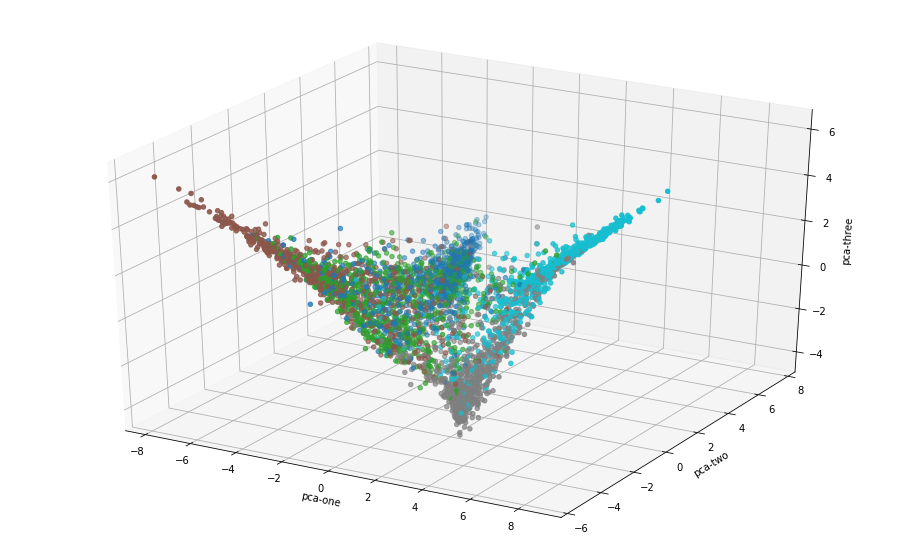

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.062s...
[t-SNE] Computed neighbors for 4000 samples in 3.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.623293
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.878029
[t-SNE] KL divergence after 300 iterations: 1.591575
t-SNE done! Time elapsed: 12.25555968284607 seconds


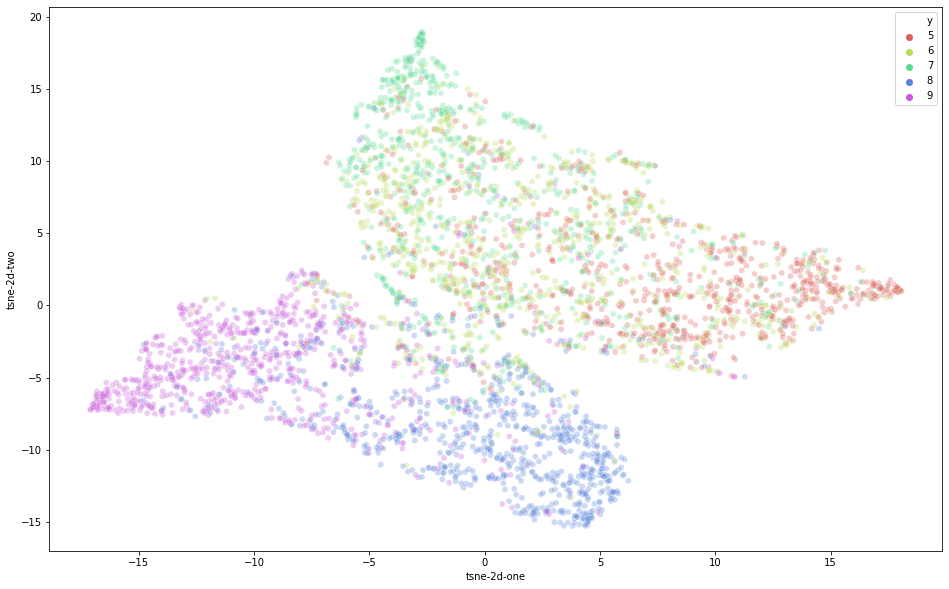

In [25]:
# Ploting the last feature for the new classes with dimension reduction 
# methods:

N = 4000
feat_cols = [ 'index'+str(i) for i in range(results.shape[1]) ]
df = pd.DataFrame(results,columns=feat_cols)
df['y'] = y_other
df['label'] = df['y'].apply(lambda i: str(i))
print('Size of the dataframe: {}'.format(df.shape))

########### PCA ##########
# np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per \
 principal component: {}'.format(pca.explained_variance_ratio_))
print('Size of the dataframe: {}'.format(df_subset.shape))
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
   xs=df_subset.loc[rndperm,:]["pca-one"], 
   ys=df_subset.loc[rndperm,:]["pca-two"], 
   zs=df_subset.loc[rndperm,:]["pca-three"], 
   c=df.loc[rndperm,:]["y"], cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

######## T-SNE Method ########
data_subset = df_subset[feat_cols].values
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
   x="tsne-2d-one", y="tsne-2d-two",hue="y",
   palette=sns.color_palette("hls", 10-num_classes),
   data=df_subset, legend="full", alpha=0.3)

# One Shot Learning

In [26]:
def compute_nearest_neighbor(vector, data_set):
 """ 
 This function returns the index of the nearest neighbor in the data_set
 while making sure that this neighbor is similar to vector.
 INPUTS:
 - vector: array of coordinates of the same dimension of the vectors in 
 data_set
 - data_set: array of vectors.
 OUTPUT:
 - nn: index of the nearest_neighbor.
 COMPUTATION TIME:
 Immediate
 """
 mini = 1000000
 nn = 0
 for i in range(data_set.shape[0]):
   elem = data_set[i,:]
   dist = np.linalg.norm(vector - elem)
   if dist != 0.:
     if dist < mini:
       nn = i
       mini = dist
 return nn

# # Test compute_nearest_neighbor:

# data_set = [[0,0], [1,4], [1,1]]
# data_set = np.array(data_set)
# vector = np.array([0,0])
# print(compute_nearest_neighbor(vector, data_set))

# Prediction evaluation on new classes:
 
# Tests:
confusion_matrix = np.zeros((10-num_classes, 10 - num_classes), dtype = int)
# ligne : prediction
# colonne : reference
nb_of_different_references = 300
accuracies = np.zeros((10-num_classes, nb_of_different_references))
for p in range(nb_of_different_references):
 index_ref = rd.randint(0, nb_examples-1)
 references = results_per_class[:,index_ref]
 for i in range(10-num_classes):
   nb_mistakes = 0
   k = 0
   for elem in results_per_class[i,:]:
     if k != index_ref:
       index = compute_nearest_neighbor(elem, references)
       confusion_matrix[index, i] += 1
       if index != i:
         nb_mistakes += 1
     k += 1
   accuracies[i, p] = 1 - nb_mistakes/(nb_examples-1)  
for num_class in range(10-num_classes):
 print("Class n°", num_class+num_classes,"accuracy:", 
       np.mean(accuracies[num_class,:]))
print("Confusion Matrix:")
print(confusion_matrix)

Class n° 5 accuracy: 0.45053720387053714
Class n° 6 accuracy: 0.3420820820820821
Class n° 7 accuracy: 0.43710710710710715
Class n° 8 accuracy: 0.5726993660326994
Class n° 9 accuracy: 0.5869235902569236
Confusion Matrix:
[[135026  73003  53406   9500   8354]
 [ 91652 102522  92661  28906  21015]
 [ 53583  85033 131001  18160   8185]
 [ 10347  23464  15258 171638  86245]
 [  9092  15678   7374  71496 175901]]


# Few Shots Learning

In [27]:
# Tests:
confusion_matrix = np.zeros((10-num_classes, 10 - num_classes), dtype = int)
# ligne : prediction
# colonne : reference
nb_of_different_references = 100
accuracies = np.zeros((10-num_classes, nb_of_different_references))
for p in range(nb_of_different_references):
  index_ref = rd.randint(0, nb_examples-3)
  references = results_per_class[:,index_ref] + results_per_class[:, index_ref +1 ] + \
  results_per_class[:,index_ref+2]
  references /= 3
  for i in range(10-num_classes):
    nb_mistakes = 0
    k = 0
    for elem in results_per_class[i,:]:
      if k != index_ref:
        index = compute_nearest_neighbor(elem, references)
        confusion_matrix[index, i] += 1
        if index != i:
          nb_mistakes += 1
      k += 1
    accuracies[i, p] = 1 - nb_mistakes/(nb_examples-1)  
for num_class in range(10-num_classes):
  print("Class n°", num_class+num_classes,"accuracy:", 
        np.mean(accuracies[num_class,:]))
print("Confusion Matrix:")
print(confusion_matrix)

Class n° 5 accuracy: 0.585875875875876
Class n° 6 accuracy: 0.3516616616616617
Class n° 7 accuracy: 0.533133133133133
Class n° 8 accuracy: 0.692872872872873
Class n° 9 accuracy: 0.7322922922922922
Confusion Matrix:
[[58529 26311 13800  2515  3019]
 [24697 35131 28017  5286  3976]
 [14704 29264 53260  2658  1557]
 [ 1426  6693  4130 69218 18192]
 [  544  2501   693 20223 73156]]
